# Importing all the necessary libraries

In [1]:
# Used to display all the matplotlib graphs inside the notebook
%matplotlib inline 

# Hiding the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
import re
import requests
from tqdm import tqdm
from datetime import datetime

In [4]:
r = requests.get('https://data.lacity.org/resource/2nrs-mtv8.json?$select=count(*)')
n_crimes = int(r.json()[0]['count'])
print('The number of crimes till date is: ', n_crimes)

The number of crimes till date is:  857658


## 1) Reading the data using API

In [5]:
API_URL = "https://data.lacity.org/resource/2nrs-mtv8.json"

In [6]:
def get_count(start_date, end_date):
    query = f"{API_URL}?$select=count(*)&$where=date_rptd between '{start_date}' and '{end_date}'"
    res = requests.get(query)
    if res.status_code != 200:
        raise Exception(f"Return code: {res.status_code}\tReturn Text: {res.content}")
        
    records_count = int(res.json()[0]['count'])
    return records_count

def get_data(start_date, end_date, limit, batch_num):
    err_corr = int(limit * 0.1)
    
    offset = (batch_num * limit) - err_corr if batch_num != 0 else 0
    limit = limit + 2*err_corr
    query = f"{API_URL}?$order=date_rptd ASC&$where=date_rptd between '{start_date}' and '{end_date}'&$limit={limit}&$offset={offset}"
    res = requests.get(query)
    if res.status_code != 200:
        raise Exception(f"Return code: {res.status_code}\tReturn Text: {res.content}")
    
    data = res.json()
    return pd.DataFrame(data)

def load_data(start_date, end_date, batch_size=50000, debug=True):
    if debug:
        return pd.read_csv("la_crime_data.csv")
    
    # Get total count of columns to load
    records_count = get_count(start_date, end_date)
    print(f"Fetching {records_count} records...")
    
    num_batches = int(records_count / batch_size) + 1
    
    # Fetch data in batches
    df = pd.DataFrame()
    all_data = []
    for batch_num in tqdm(range(num_batches)):
        batch_data = get_data(start_date, end_date, batch_size, batch_num)
        all_data.append(batch_data)      
    
    return pd.concat(all_data).drop_duplicates()

In [7]:
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

In [8]:
# crime_data = load_data(start_date, end_date, debug=False)
# crime_data.to_csv('la_crime_data.csv', index=False)
crime_data = load_data(start_date, end_date)

In [9]:
crime_data.shape

(852950, 28)

In [10]:
sns.set() # Setting the default seaborn style for all the plots

In [11]:
data = crime_data[:]

# Exploratory Data Analysis

## 2)  Number of records, structure of the file, number of attributes

In [12]:
data.shape # The data has got 195 rows and 24 columns

(852950, 28)

In [13]:
data.head() # Checking the head of the data frame

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,crm_cd_1,crm_cd_2,location,lat,lon,weapon_used_cd,weapon_desc,cross_street,crm_cd_3,crm_cd_4
0,191501505,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,745.0,998.0,5400 CORTEEN PL,34.1685,-118.4019,NaN,NaN,NaN,NaN,NaN
1,191921269,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,740.0,NaN,14400 TITUS ST,34.2198,-118.4468,NaN,NaN,NaN,NaN,NaN
2,200104020,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,245,1,Central,153,1,350,"THEFT, PERSON",...,350.0,624.0,6TH ST,34.0463,-118.2515,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",SPRING ST,NaN,NaN
3,200104024,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,325,1,Central,134,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,740.0,NaN,4TH ST,34.0503,-118.2504,NaN,NaN,HILL ST,NaN,NaN
4,200104027,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,30,1,Central,182,2,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,...,930.0,NaN,700 W 9TH ST,34.0458,-118.2614,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",NaN,NaN,NaN


In [14]:
# Checking for duplicates and removing the duplicates

print('The shape before removing the duplicates from the data set is :',data.shape)
data = data.drop_duplicates()
print('The shape after removing the duplicates from the data set is :',data.shape)

The shape before removing the duplicates from the data set is : (852950, 28)
The shape after removing the duplicates from the data set is : (852950, 28)


In [15]:
data.info() # Checking for the data type of each of the variables and the number of non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852950 entries, 0 to 852949
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dr_no           852950 non-null  int64  
 1   date_rptd       852950 non-null  object 
 2   date_occ        852950 non-null  object 
 3   time_occ        852950 non-null  int64  
 4   area            852950 non-null  int64  
 5   area_name       852950 non-null  object 
 6   rpt_dist_no     852950 non-null  int64  
 7   part_1_2        852950 non-null  int64  
 8   crm_cd          852950 non-null  int64  
 9   crm_cd_desc     852950 non-null  object 
 10  mocodes         734639 non-null  object 
 11  vict_age        852950 non-null  int64  
 12  vict_sex        740344 non-null  object 
 13  vict_descent    740336 non-null  object 
 14  premis_cd       852940 non-null  float64
 15  premis_desc     852432 non-null  object 
 16  status          852950 non-null  object 
 17  status_des

In [16]:
# Percentage of null values in each of the 28 columns
((data.isnull().sum()).sort_values(ascending=False) / data.shape[0])*100

crm_cd_4          99.992731
crm_cd_3          99.752272
crm_cd_2          92.670028
cross_street      84.095082
weapon_desc       65.209215
weapon_used_cd    65.209215
mocodes           13.870801
vict_descent      13.202884
vict_sex          13.201946
premis_desc        0.060730
crm_cd_1           0.001290
premis_cd          0.001172
vict_age           0.000000
crm_cd_desc        0.000000
date_rptd          0.000000
crm_cd             0.000000
status             0.000000
status_desc        0.000000
part_1_2           0.000000
rpt_dist_no        0.000000
location           0.000000
lat                0.000000
lon                0.000000
area_name          0.000000
area               0.000000
time_occ           0.000000
date_occ           0.000000
dr_no              0.000000
dtype: float64

## Data Cleaning

In [17]:
# data['date_rptd'] = data['date_rptd'].datetime.strptime('2020-01-01T00:00:00.000', '%Y-%m-%dT%H:%M:%S.000').date()
data['date_rptd'] = pd.to_datetime(data['date_rptd'])
data['date_occ'] = pd.to_datetime(data['date_occ'])

In [18]:
data['time_occ'] = data['time_occ'].astype('str')
data['time_occ'] = data['time_occ'].str.zfill(4)
data['time_occ'] = data['time_occ'].str[0:-2] + ':' + data['time_occ'].str[-2:]
data['time_occ'] = pd.to_datetime(data['time_occ'], format='%H:%M').dt.hour

In [19]:
# new derived column segments the ages into groups
age_groups = [
    (data['vict_age'] < 1),
    (data['vict_age'] >= 1) & (data['vict_age'] <= 12),
    (data['vict_age'] >= 13) & (data['vict_age'] < 18),
    (data['vict_age'] >= 18) & (data['vict_age'] < 65),
    (data['vict_age'] >= 65)
]

labels = ['Unknown' ,'Child', 'Teenager', 'Adult', 'Old']

# create new column 'Age Group'
data['Age Group'] = np.select(age_groups, labels)

In [20]:
# data['vict_sex'][(data['vict_sex']=='H') | (data['vict_sex']=='-')] = 'Unknown'
# replace values with the full gender name and add 'H' vales to Unknown label
data['vict_sex'].replace({'M':'Male', 'F':'Female', 'X':'Unknown', 'H':'Unknown', '-':'Unknown'}, inplace = True)

# fill null values with 'Unknown'
data['vict_sex'].fillna('Data Missing', inplace=True)

In [21]:
# what unique values we have here?
data['vict_descent'].value_counts()

vict_descent
H    261145
W    173440
B    120896
X     83214
O     67532
A     18700
K      4579
F      3580
C      3313
J      1181
V       893
I       805
Z       426
P       229
U       170
D        66
G        63
L        56
S        46
-         2
Name: count, dtype: int64

In [22]:
# replace values with its corresponding label
descent_mapping = {
    'A': 'Other Asian',
    'B': 'Black',
    'C': 'Chinese',
    'D': 'Cambodian',
    'F': 'Filipino',
    'G': 'Guamanian',
    'H': 'Hispanic/Latin/Mexican',
    'I': 'American Indian/Alaskan Native',
    'J': 'Japanese',
    'K': 'Korean', 
    'L': 'Laotian',
    'O': 'Other',
    'P': 'Pacific Islander',
    'S': 'Samoan',
    'U': 'Hawaiian',
    'V': 'Vietnamese',
    'W': 'White',
    'X': 'Unknown',
    '-': 'Unknown',
    'Z': 'Asian Indian'
}

data['vict_descent'].replace(descent_mapping, inplace = True)

# fill null values with 'Unknown'
data['vict_descent'].fillna('Data Missing', inplace=True)

In [23]:
# fill null values with 'Unknown'
data['premis_desc'].fillna('Data Missing', inplace=True)

In [24]:
# what unique values we have here?
data['status_desc'].value_counts()

status_desc
Invest Cont     683107
Adult Other      91576
Adult Arrest     74004
Juv Arrest        2775
Juv Other         1484
UNK                  4
Name: count, dtype: int64

In [25]:
data['weapon_desc'].fillna('Data Missing', inplace=True)

In [26]:
# Replace Other Missing Values in columns like 'cross_street' and 'mocodes' with 'Unknown'
data.fillna(value='Data Missing', inplace=True)

In [27]:
data.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'status', 'status_desc', 'crm_cd_1', 'crm_cd_2', 'location', 'lat',
       'lon', 'weapon_used_cd', 'weapon_desc', 'cross_street', 'crm_cd_3',
       'crm_cd_4', 'Age Group'],
      dtype='object')

In [28]:
# Rename all the columns
data = data.rename(columns=
                   {'lat': 'Latitude', 
                    'lon': 'Longitude',
                    'status_desc': 'Case Status',
                    'premis_desc': 'Crime Location',
                    'vict_descent': 'Victim Descent',
                    'vict_sex': 'Victim Gender',
                    'weapon_desc': 'Weapon Description',
                    'vict_age': 'Victim Age',
                    'mocodes': 'Modus Operandi',
                    'date_rptd': 'Date Reported',
                    'date_occ' : 'Date Occured',
                    'time_occ' : 'Time Occured',
                    'part_1_2' : 'Part 1-2',
                    'location' : 'Street Address',
                    'crm_cd' : 'Crime Code',
                    'crm_cd_desc' : 'Crime Description',
                    'area' : 'Area Code'
                   }
                  )

In [29]:
# remove unnecessary columns for the analysis
data.drop(['premis_cd', 'crm_cd_1', 'crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'status', 'weapon_used_cd'],
          axis=1,
          inplace=True)

In [30]:
data['Latitude'] = data['Latitude'].replace(0, np.nan)
data['Longitude'] = data['Longitude'].replace(0, np.nan)

In [31]:
columns = []
for column in data.columns:
    column = column.replace("_", " ")
    column = column.title()
    columns.append(column)
    
data.columns = columns

data.head()

,Dr No,Date Reported,Date Occured,Time Occured,Area Code,Area Name,Rpt Dist No,Part 1-2,Crime Code,Crime Description,...,Victim Gender,Victim Descent,Crime Location,Case Status,Street Address,Latitude,Longitude,Weapon Description,Cross Street,Age Group
0,191501505,2020-01-01,2020-01-01,17,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,Female,White,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Invest Cont,5400 CORTEEN PL,34.1685,-118.4019,Data Missing,Data Missing,Old
1,191921269,2020-01-01,2020-01-01,4,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Unknown,Unknown,BEAUTY SUPPLY STORE,Invest Cont,14400 TITUS ST,34.2198,-118.4468,Data Missing,Data Missing,Adult
2,200104020,2020-01-01,2020-01-01,2,1,Central,153,1,350,"THEFT, PERSON",...,Male,Black,SIDEWALK,Invest Cont,6TH ST,34.0463,-118.2515,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",SPRING ST,Adult
3,200104024,2020-01-01,2020-01-01,3,1,Central,134,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Male,Other Asian,"VEHICLE, PASSENGER/TRUCK",Invest Cont,4TH ST,34.0503,-118.2504,Data Missing,HILL ST,Adult
4,200104027,2020-01-01,2020-01-01,0,1,Central,182,2,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,...,Male,Other,PARKING LOT,Invest Cont,700 W 9TH ST,34.0458,-118.2614,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Data Missing,Adult


In [32]:
# Function to remove text inside brackets
def remove_text_inside_brackets(sentence):
    return pd.Series(sentence).replace(to_replace='\(.*?\)', value='', regex=True)[0]

# Apply the function to each row in the 'Crime Description' column
data['Crime Description'] = data['Crime Description'].apply(remove_text_inside_brackets)
data['Crime Description'] = data['Crime Description'].str.replace(',', '-').str.strip().str.title()

In [33]:
# Apply the function to each row in the 'Crime Description' column
data['Weapon Description'] = data['Weapon Description'].apply(remove_text_inside_brackets)
data['Weapon Description'] = data['Weapon Description'].str.replace(',', '-').str.strip().str.title()

In [34]:
data['Crime Location'] = data['Crime Location'].str.strip().str.title()

In [35]:
data['Crime Location'] = data['Crime Location'].str.replace("*","")

In [36]:
data['Street Address'] = data['Street Address'].str.strip().str.title()

In [37]:
def remove_extra_spaces(address_string):
    res = re.sub(' +', ' ', address_string)
    return res
data['Street Address'] = data['Street Address'].apply(remove_extra_spaces)

In [38]:
data.head()

,Dr No,Date Reported,Date Occured,Time Occured,Area Code,Area Name,Rpt Dist No,Part 1-2,Crime Code,Crime Description,...,Victim Gender,Victim Descent,Crime Location,Case Status,Street Address,Latitude,Longitude,Weapon Description,Cross Street,Age Group
0,191501505,2020-01-01,2020-01-01,17,15,N Hollywood,1543,2,745,Vandalism - Misdeameanor,...,Female,White,"Multi-Unit Dwelling (Apartment, Duplex, Etc)",Invest Cont,5400 Corteen Pl,34.1685,-118.4019,Data Missing,Data Missing,Old
1,191921269,2020-01-01,2020-01-01,4,19,Mission,1998,2,740,Vandalism - Felony,...,Unknown,Unknown,Beauty Supply Store,Invest Cont,14400 Titus St,34.2198,-118.4468,Data Missing,Data Missing,Adult
2,200104020,2020-01-01,2020-01-01,2,1,Central,153,1,350,Theft- Person,...,Male,Black,Sidewalk,Invest Cont,6Th St,34.0463,-118.2515,Strong-Arm,SPRING ST,Adult
3,200104024,2020-01-01,2020-01-01,3,1,Central,134,2,740,Vandalism - Felony,...,Male,Other Asian,"Vehicle, Passenger/Truck",Invest Cont,4Th St,34.0503,-118.2504,Data Missing,HILL ST,Adult
4,200104027,2020-01-01,2020-01-01,0,1,Central,182,2,930,Criminal Threats - No Weapon Displayed,...,Male,Other,Parking Lot,Invest Cont,700 W 9Th St,34.0458,-118.2614,Strong-Arm,Data Missing,Adult


In [39]:
data.shape

(852950, 22)

In [40]:
# % of null values in each of the columns after data cleaning
(data.isnull().sum()/data.shape[0])*100

Dr No                 0.000000
Date Reported         0.000000
Date Occured          0.000000
Time Occured          0.000000
Area Code             0.000000
Area Name             0.000000
Rpt Dist No           0.000000
Part 1-2              0.000000
Crime Code            0.000000
Crime Description     0.000000
Modus Operandi        0.000000
Victim Age            0.000000
Victim Gender         0.000000
Victim Descent        0.000000
Crime Location        0.000000
Case Status           0.000000
Street Address        0.000000
Latitude              0.265314
Longitude             0.265314
Weapon Description    0.000000
Cross Street          0.000000
Age Group             0.000000
dtype: float64

In [41]:
# Getting a count of number of unique values in each column so as to identify the continuous and discrete variables
data.nunique()

Dr No                 852950
Date Reported           1434
Date Occured            1434
Time Occured              24
Area Code                 21
Area Name                 21
Rpt Dist No             1206
Part 1-2                   2
Crime Code               138
Crime Description        137
Modus Operandi        282657
Victim Age               103
Victim Gender              4
Victim Descent            20
Crime Location           307
Case Status                6
Street Address         64227
Latitude                5407
Longitude               4970
Weapon Description        80
Cross Street            9840
Age Group                  5
dtype: int64

## Data Exploration

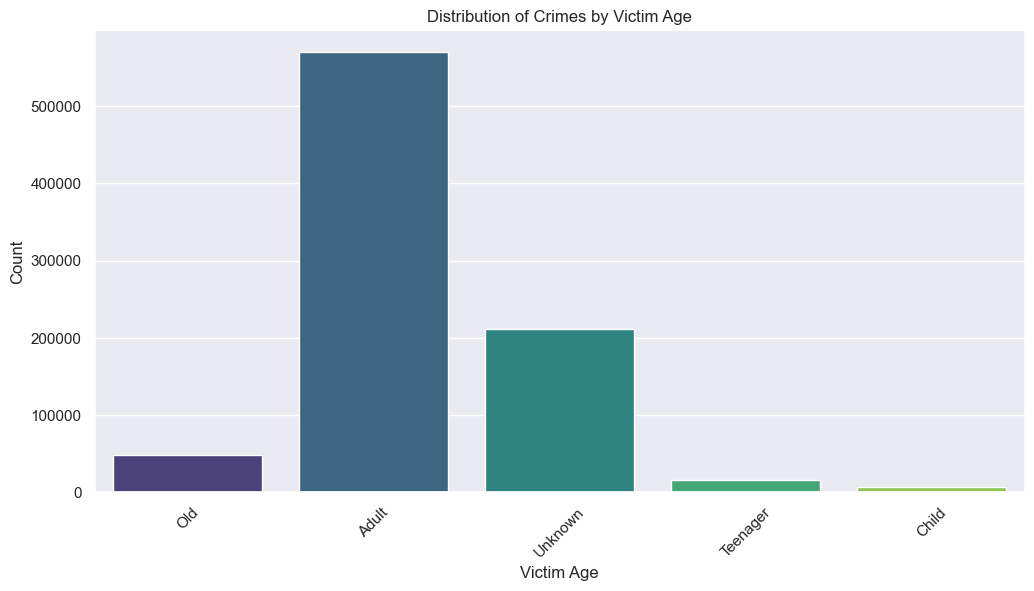

In [42]:
# Create a bar plot for Victim Age and Count
plt.figure(figsize=(12, 6))
sns.countplot(x='Age Group', data=data, palette='viridis')
plt.title('Distribution of Crimes by Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

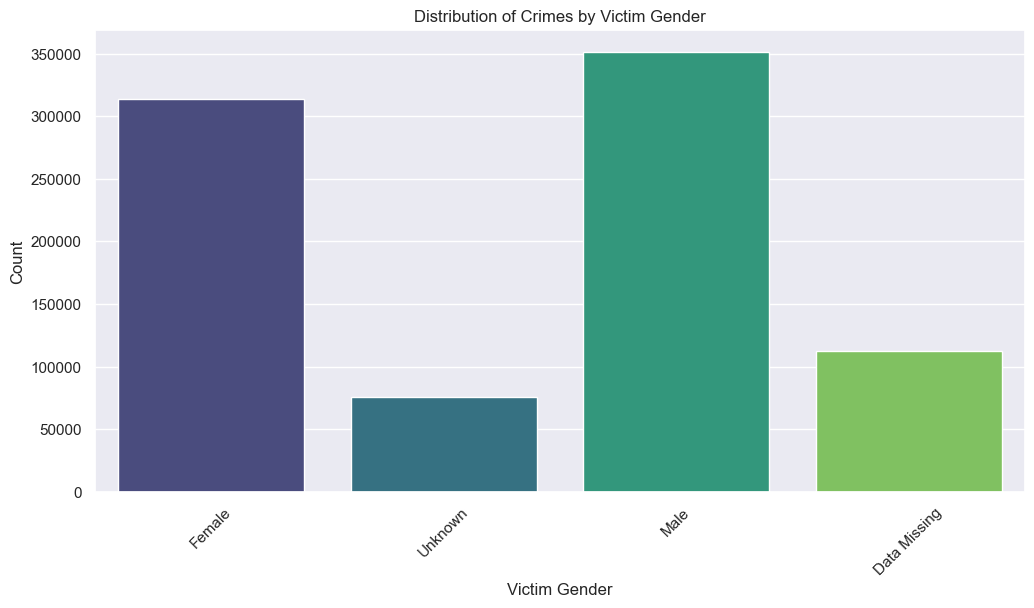

In [43]:
# Create a bar plot for Victim Age and Count
plt.figure(figsize=(12, 6))
sns.countplot(x='Victim Gender', data=data, palette='viridis')
plt.title('Distribution of Crimes by Victim Gender')
plt.xlabel('Victim Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

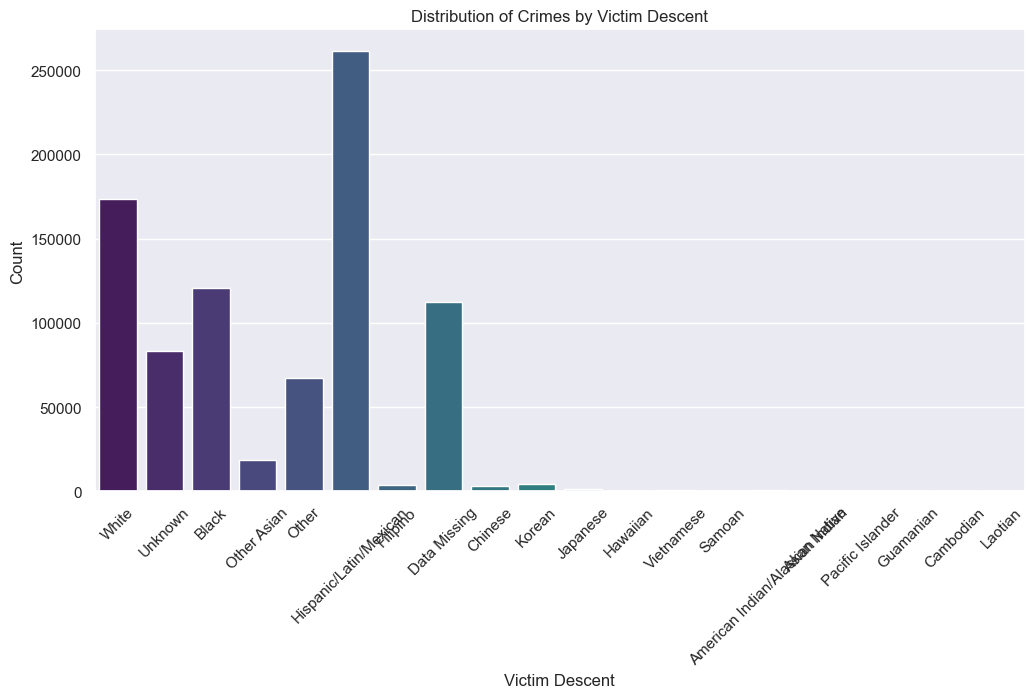

In [44]:
# Create a bar plot for Victim Age and Count
plt.figure(figsize=(12, 6))
sns.countplot(x='Victim Descent', data=data, palette='viridis')
plt.title('Distribution of Crimes by Victim Descent')
plt.xlabel('Victim Descent')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

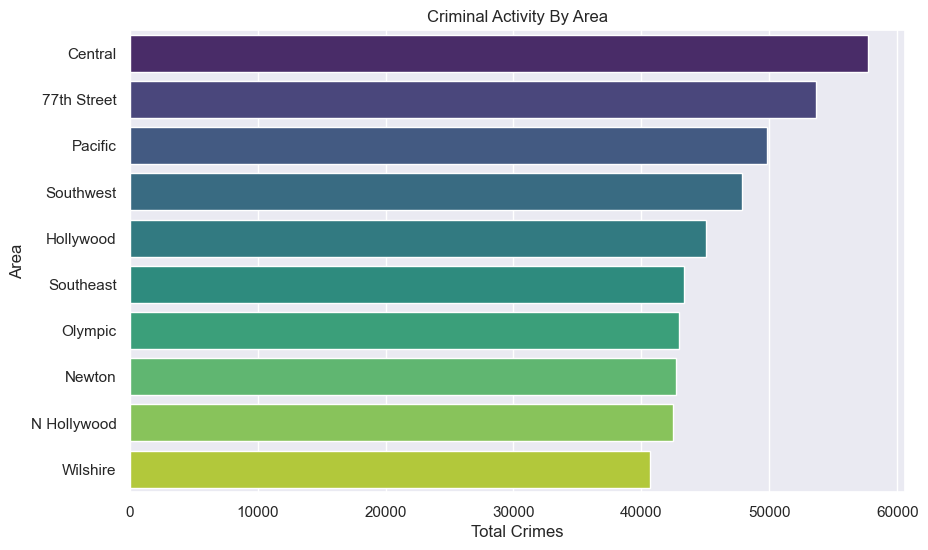

In [45]:
# Aggregate by area
by_area = data.groupby('Area Name').size().reset_index(name='Total')

# Sort and get the top 10
top_areas = by_area.sort_values(by='Total', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Total', y='Area Name', data=top_areas, palette='viridis')
plt.title('Criminal Activity By Area')
plt.xlabel('Total Crimes')
plt.ylabel('Area')
plt.show()

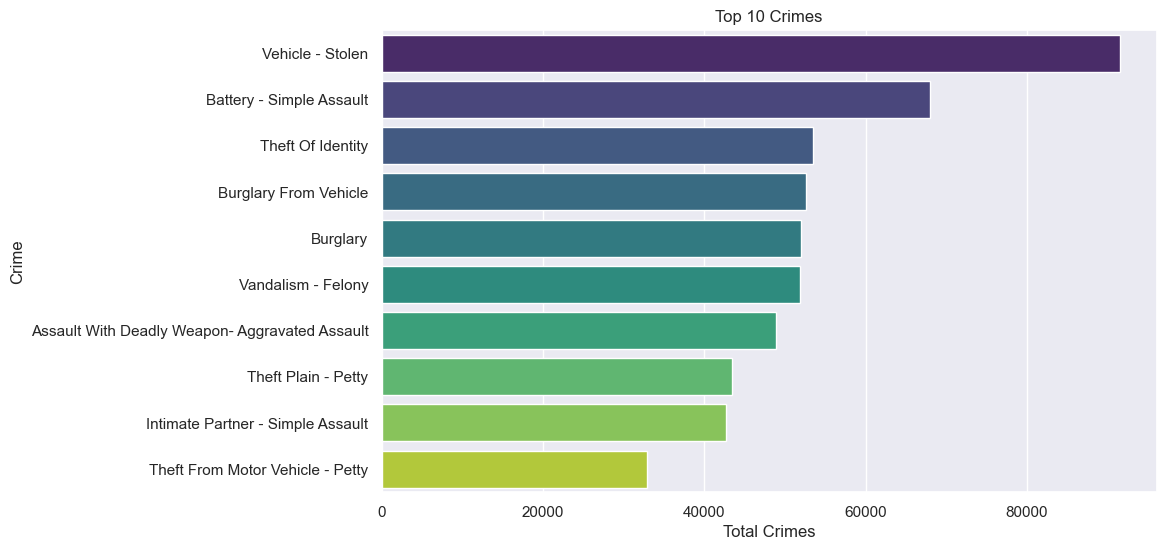

In [46]:
# Aggregate by area
by_area = data.groupby('Crime Description').size().reset_index(name='Total')

# Sort and get the top 10
top_areas = by_area.sort_values(by='Total', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Total', y='Crime Description', data=top_areas, palette='viridis')
plt.title('Top 10 Crimes')
plt.xlabel('Total Crimes')
plt.ylabel('Crime')
plt.show()

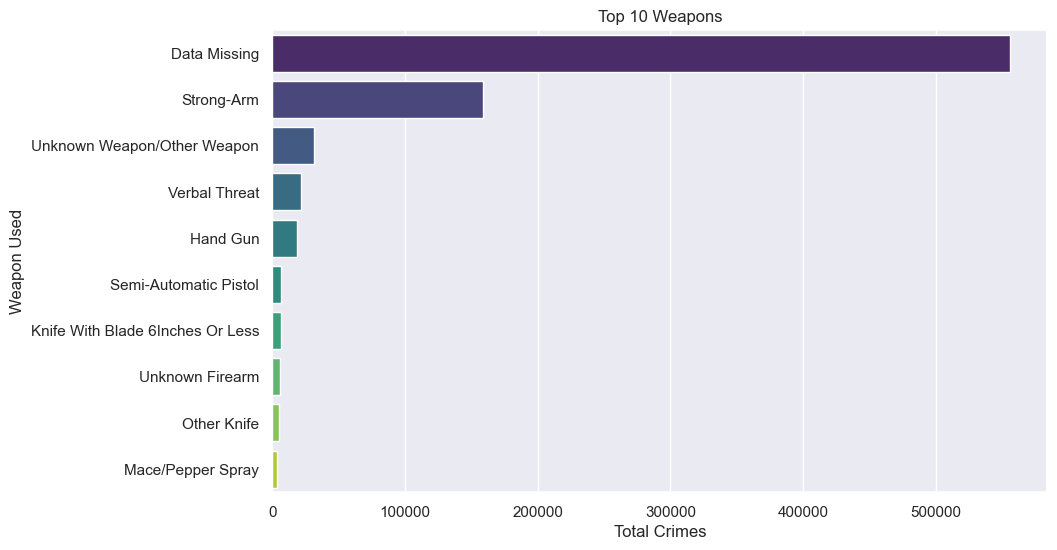

In [47]:
# Aggregate by area
by_area = data.groupby('Weapon Description').size().reset_index(name='Total')

# Sort and get the top 10
top_areas = by_area.sort_values(by='Total', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Total', y='Weapon Description', data=top_areas, palette='viridis')
plt.title('Top 10 Weapons')
plt.xlabel('Total Crimes')
plt.ylabel('Weapon Used')
plt.show()

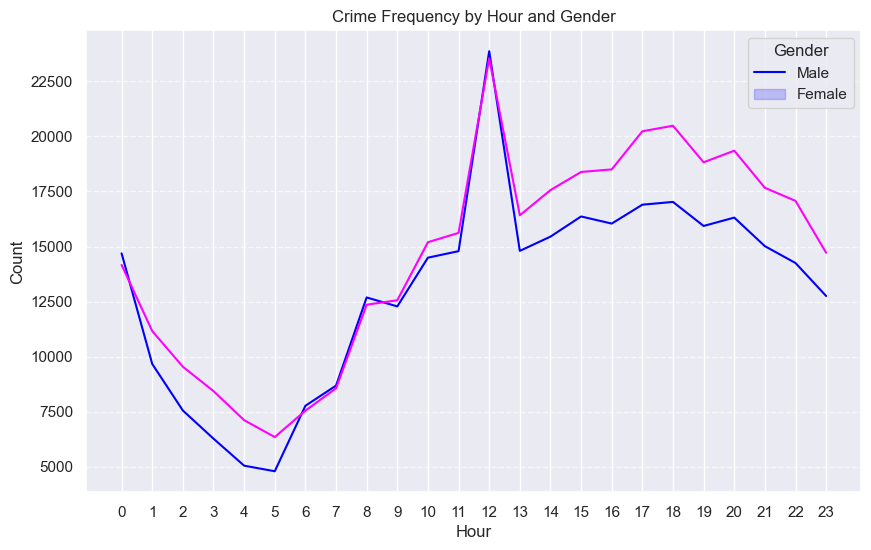

In [48]:
# Filter and group by hour and gender
crime_hour_gender = data[data['Victim Gender'].isin(['Male', 'Female'])]
crime_hour_gender = crime_hour_gender.groupby(['Time Occured', 'Victim Gender']).size().reset_index(name='crime_count')

# Plotting using seaborn and matplotlib
plt.figure(figsize=(10, 6))
sns.lineplot(data=crime_hour_gender, x='Time Occured', y='crime_count', hue='Victim Gender', palette=['blue', 'magenta'])
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Crime Frequency by Hour and Gender')
plt.xticks(range(0, 24, 1))
plt.legend(title='Gender', labels=['Male', 'Female'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [49]:
# Get top 10 values and their counts for the 'Ethnicity' column
top_ethnicities = data['Victim Descent'].value_counts().head(10)
top_ethinicites = top_ethnicities.index.to_list()

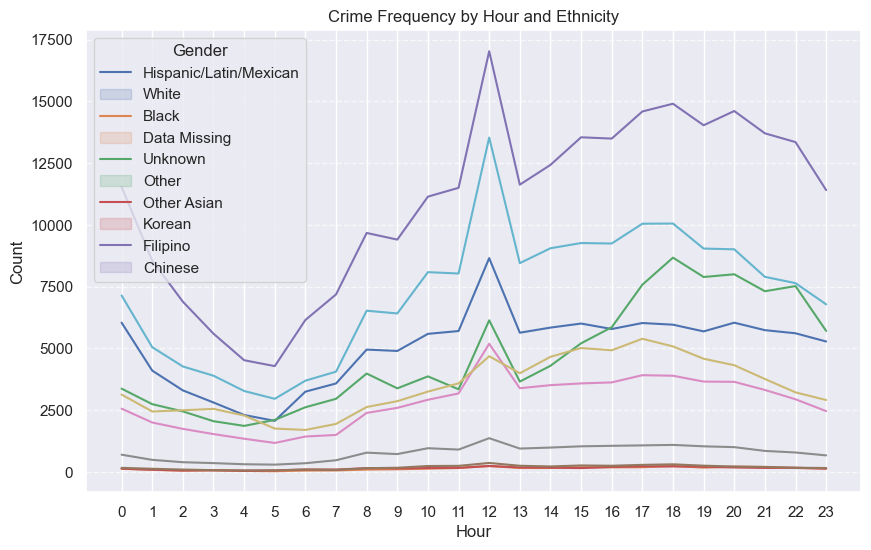

In [50]:
# Filter and group by hour and gender
crime_hour_descent = data[data['Victim Descent'].isin(top_ethinicites)]
crime_hour_descent = crime_hour_descent.groupby(['Time Occured', 'Victim Descent']).size().reset_index(name='crime_count')

# Plotting using seaborn and matplotlib
plt.figure(figsize=(10, 6))
sns.lineplot(data=crime_hour_descent, x='Time Occured', y='crime_count', hue='Victim Descent')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Crime Frequency by Hour and Ethnicity')
plt.xticks(range(0, 24, 1))
plt.legend(title='Gender', labels=top_ethinicites)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [51]:
## mocodes



In [52]:
data.head()

,Dr No,Date Reported,Date Occured,Time Occured,Area Code,Area Name,Rpt Dist No,Part 1-2,Crime Code,Crime Description,...,Victim Gender,Victim Descent,Crime Location,Case Status,Street Address,Latitude,Longitude,Weapon Description,Cross Street,Age Group
0,191501505,2020-01-01,2020-01-01,17,15,N Hollywood,1543,2,745,Vandalism - Misdeameanor,...,Female,White,"Multi-Unit Dwelling (Apartment, Duplex, Etc)",Invest Cont,5400 Corteen Pl,34.1685,-118.4019,Data Missing,Data Missing,Old
1,191921269,2020-01-01,2020-01-01,4,19,Mission,1998,2,740,Vandalism - Felony,...,Unknown,Unknown,Beauty Supply Store,Invest Cont,14400 Titus St,34.2198,-118.4468,Data Missing,Data Missing,Adult
2,200104020,2020-01-01,2020-01-01,2,1,Central,153,1,350,Theft- Person,...,Male,Black,Sidewalk,Invest Cont,6Th St,34.0463,-118.2515,Strong-Arm,SPRING ST,Adult
3,200104024,2020-01-01,2020-01-01,3,1,Central,134,2,740,Vandalism - Felony,...,Male,Other Asian,"Vehicle, Passenger/Truck",Invest Cont,4Th St,34.0503,-118.2504,Data Missing,HILL ST,Adult
4,200104027,2020-01-01,2020-01-01,0,1,Central,182,2,930,Criminal Threats - No Weapon Displayed,...,Male,Other,Parking Lot,Invest Cont,700 W 9Th St,34.0458,-118.2614,Strong-Arm,Data Missing,Adult


## Statistical Information About Crime Data in Los Angeles

In [53]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Dr No,852950.0,216696889.412709,817.0,210218370.25,220218357.5,230109433.75,239930556.0,11000814.612442
Date Reported,852950,2022-01-19 08:16:11.356350720,2020-01-01 00:00:00,2021-02-08 00:00:00,2022-02-11 00:00:00,2023-01-06 00:00:00,2023-12-04 00:00:00,NaN
Date Occured,852950,2022-01-08 15:48:45.236882944,2020-01-01 00:00:00,2021-01-26 00:00:00,2022-01-30 00:00:00,2022-12-25 00:00:00,2023-12-04 00:00:00,NaN
Time Occured,852950.0,13.185609,0.0,9.0,14.0,19.0,23.0,6.535645
Area Code,852950.0,10.707354,1.0,6.0,11.0,16.0,21.0,6.097178
Rpt Dist No,852950.0,1117.16549,101.0,615.0,1141.0,1617.0,2199.0,609.716073
Part 1-2,852950.0,1.412575,1.0,1.0,1.0,2.0,2.0,0.492298
Crime Code,852950.0,500.746338,110.0,331.0,442.0,626.0,956.0,207.705242
Victim Age,852950.0,29.742191,-3.0,5.0,31.0,45.0,120.0,21.79947
Latitude,850687.0,34.073634,33.7061,34.0146,34.0587,34.1639,34.3343,0.111019


In [54]:
# Duration
duration = (data["Date Occured"].max() - data["Date Occured"].min()).days
print("There are {} crimes commited over {} days. On average, there are {} crimes each day.".format(len(data), duration, int(len(data)/duration)))

There are 852950 crimes commited over 1433 days. On average, there are 595 crimes each day.


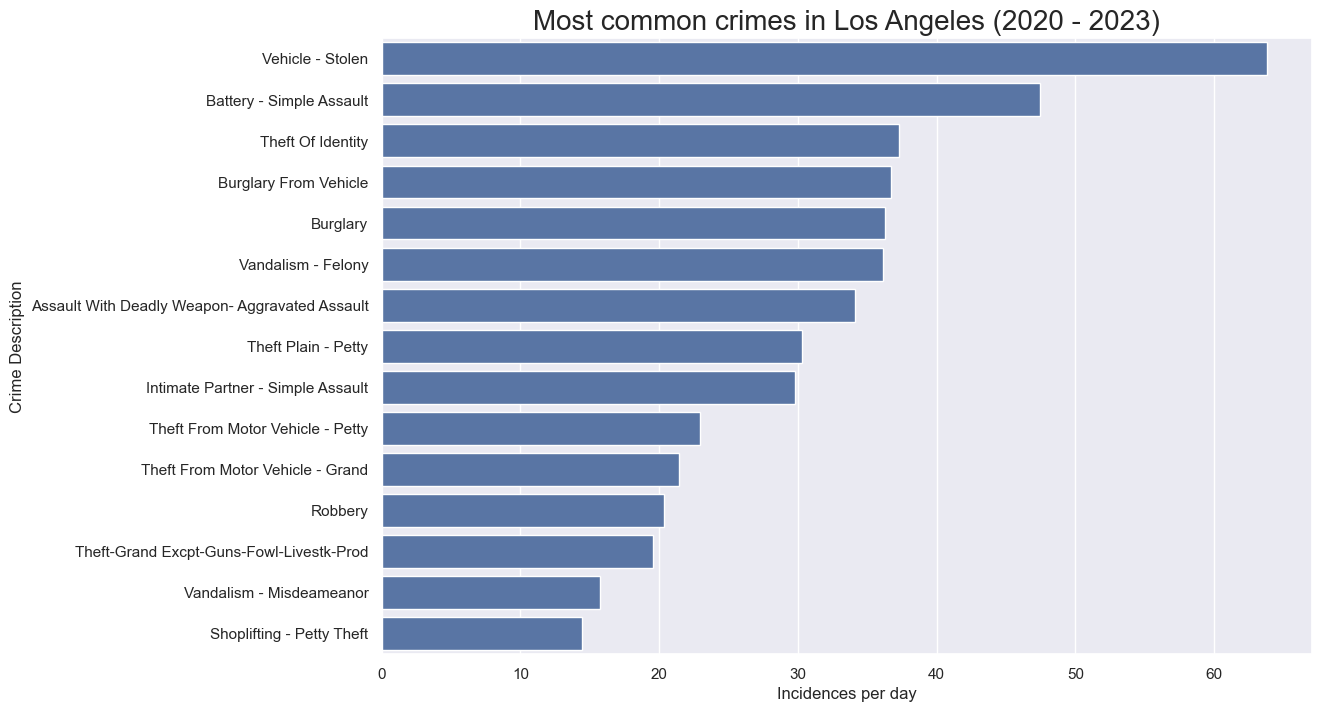

In [55]:
crime_freq = data["Crime Description"].value_counts()

plt.rcParams["figure.figsize"] = (12, 8) # Set the default scale for the rest of the notebook
plt.rcParams['axes.titlesize'] = 20
sns.barplot(x = crime_freq.values[:15]/duration, y = crime_freq.index[:15])
plt.title("Most common crimes in Los Angeles (2020 - 2023)")
plt.xlabel("Incidences per day");

In [56]:
crime_freq_df = crime_freq.to_frame().reset_index()
crime_freq_df.columns = ["Crime", "Crime Count"]
crime_freq_df['Percentage'] = crime_freq_df['Crime Count']/crime_freq_df['Crime Count'].sum()*100
crime_freq_df['Cumulative Percentage'] = crime_freq_df["Percentage"].cumsum()

In [57]:
crime_freq_df[crime_freq_df['Cumulative Percentage'] <= 75]

,Crime,Crime Count,Percentage,Cumulative Percentage
0,Vehicle - Stolen,91473,10.724310,10.724310
1,Battery - Simple Assault,67976,7.969518,18.693827
2,Theft Of Identity,53467,6.268480,24.962307
3,Burglary From Vehicle,52611,6.168122,31.130430
4,Burglary,51961,6.091916,37.222346
5,Vandalism - Felony,51826,6.076089,43.298435
6,Assault With Deadly Weapon- Aggravated Assault,48876,5.730230,49.028665
7,Theft Plain - Petty,43402,5.088458,54.117123
8,Intimate Partner - Simple Assault,42729,5.009555,59.126678
9,Theft From Motor Vehicle - Petty,32875,3.854270,62.980948


In [58]:
data['Delay'] = (data['Date Reported'] - data['Date Occured']).dt.days

In [59]:
data['Delay Category'] = pd.cut(
    x=data["Delay"],
    bins=[-1, 0, 1, 2, 7, 30, 365, np.inf],
    labels=["Same day","1 day","2 days",'3-7 days','8-30 days','1 month-1 year','More than 1 year'])

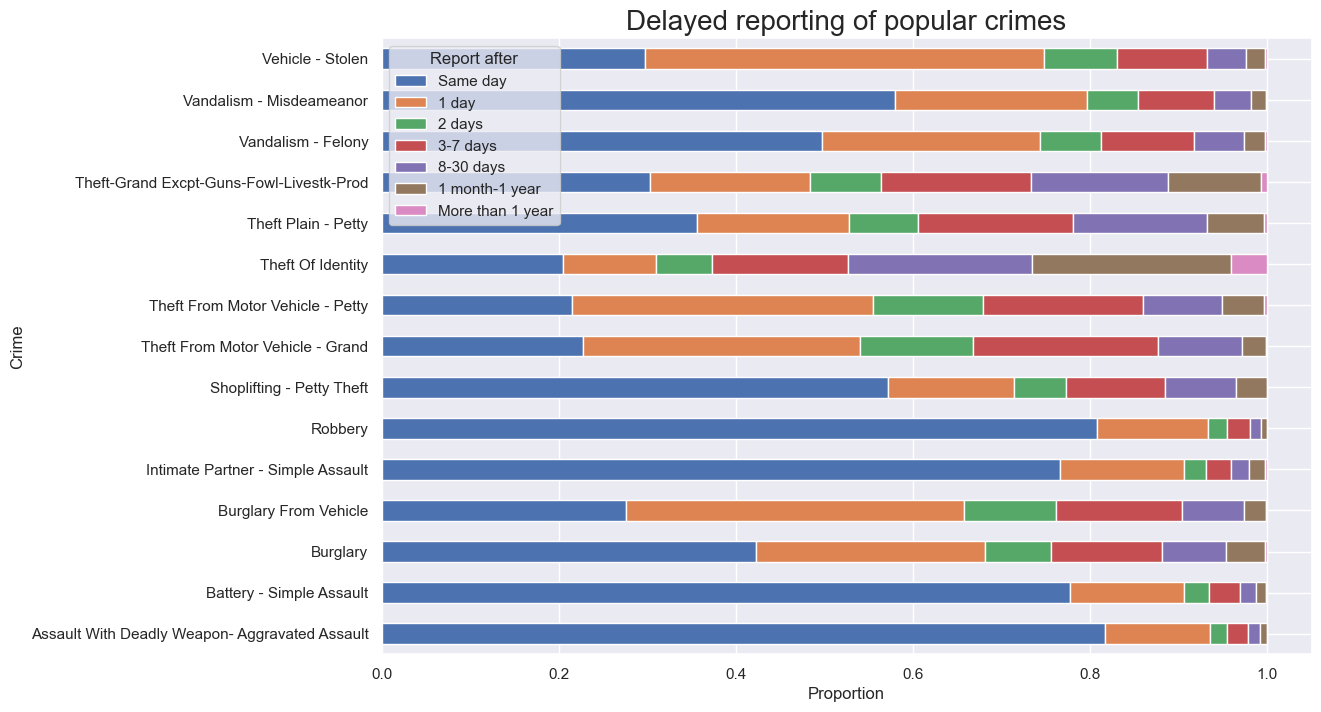

In [60]:
top_crime = crime_freq_df.iloc[:15,0]
top_crime_delay = data[data['Crime Description'].isin(top_crime)].groupby("Crime Description")['Delay Category'].value_counts(normalize=True).unstack()

top_crime_delay.plot.barh(stacked = True)
plt.title('Delayed reporting of popular crimes')
plt.ylabel('Crime')
plt.xlabel('Proportion')
plt.legend(title = "Report after");

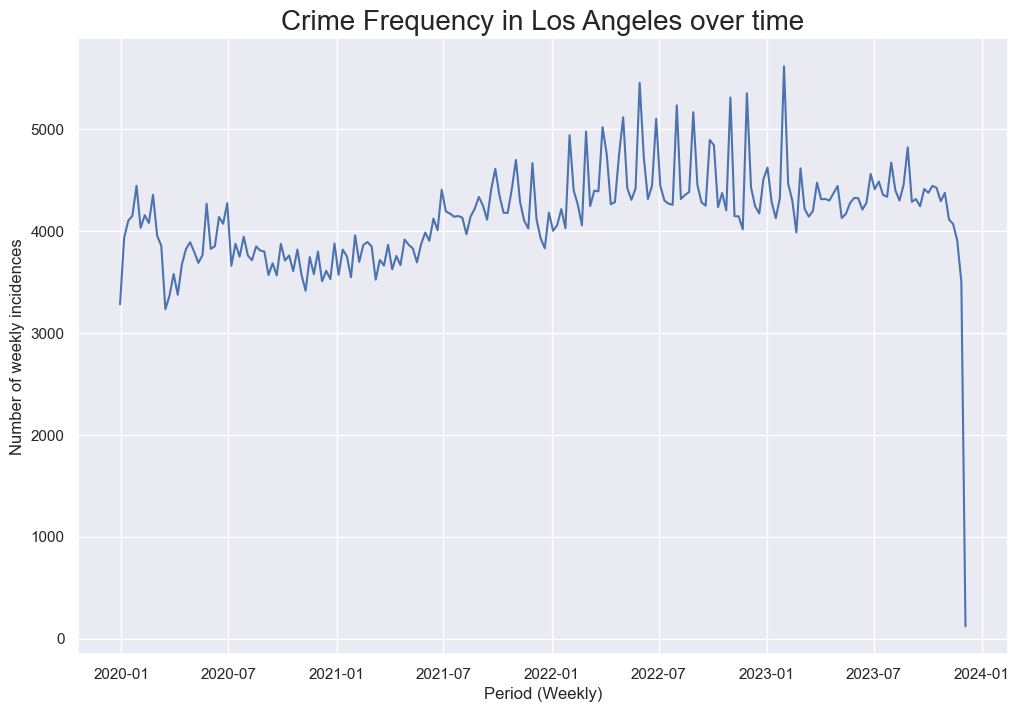

In [61]:
# Weekly occurence
data['Week Period'] = pd.DatetimeIndex(data["Date Occured"]).to_period('W').to_timestamp()
# Monthly occurence
data['Month Period'] = pd.DatetimeIndex(data["Date Occured"]).to_period('M').to_timestamp()

crime_time = data.groupby("Week Period").size().reset_index(name='Crime Count')

plt.figure(figsize=(12,8))
sns.lineplot(x=crime_time['Week Period'], y=crime_time['Crime Count'])
plt.title("Crime Frequency in Los Angeles over time")
plt.ylabel("Number of weekly incidences")
plt.xlabel("Period (Weekly)");

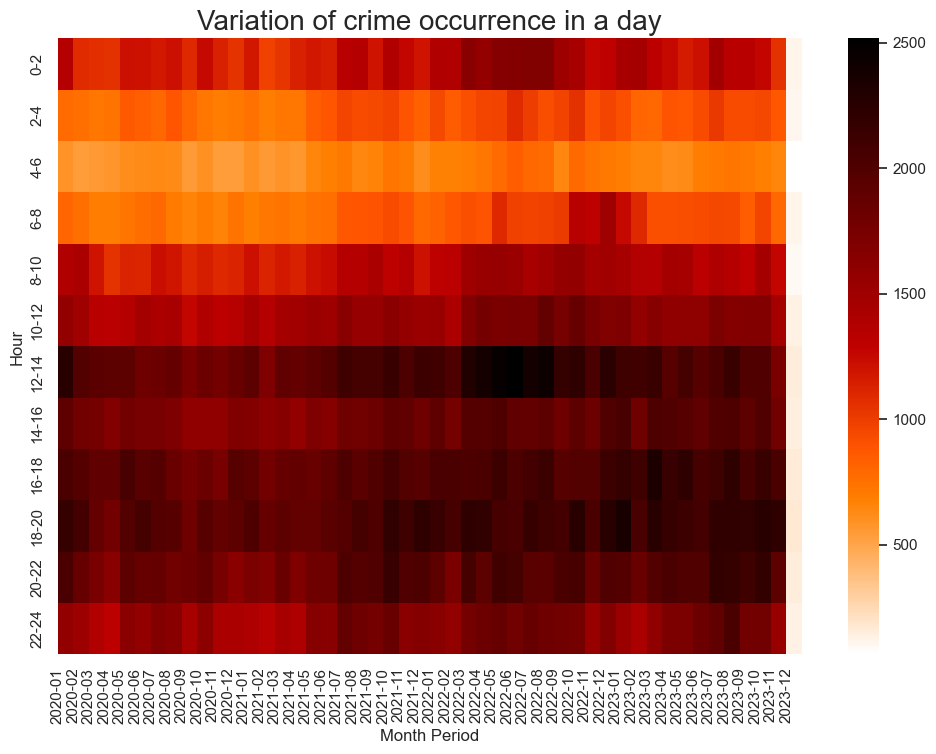

In [62]:
data['Time Slot'] = pd.cut(x=data["Time Occured"],
    bins=[-np.inf, 1.59, 3.59, 5.59, 7.59, 9.59, 11.59, 13.59, 15.59, 17.59, 19.59, 21.59, np.inf],
    labels=['0-2','2-4','4-6','6-8','8-10','10-12','12-14', '14-16', '16-18','18-20','20-22','22-24'])

crime_hour = data.groupby(['Time Slot', 'Month Period']).size().reset_index(name='Crime Count')
crime_hour_table = crime_hour.pivot(index='Time Slot', columns='Month Period', values='Crime Count')
sns.heatmap(crime_hour_table, cmap = "gist_heat_r")
plt.title("Variation of crime occurrence in a day")
plt.xticks(np.arange(0, 48, 1),labels = crime_hour_table.columns.to_period('M'))
plt.xlabel("Month Period")
plt.ylabel("Hour");

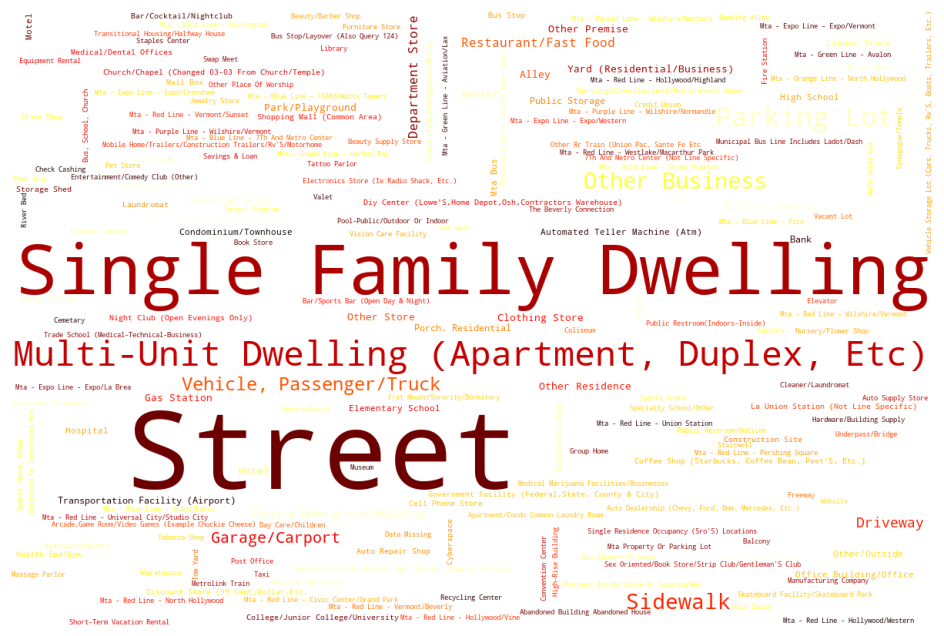

In [63]:
# Creating la mask
# los_angeles_mask = np.array(Image.open(r'C:/Users/subra/Downloads/la-map.jpg'))

#Grab the mask colors
# colors = ImageColorGenerator(los_angeles_mask)

premis_occurred = data['Crime Location'].value_counts().head(200)
# Create a dictionary
premis_dict = {}
for i in range(len(premis_occurred)):
    a = premis_occurred.index[i]
    x = premis_occurred.values[i]
    premis_dict[a] = x
    
wordcloud = WordCloud(width=1200,
        height=800,
        random_state=15,
        background_color="white",
        colormap="hot",
        collocations=False).generate_from_frequencies(premis_dict)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

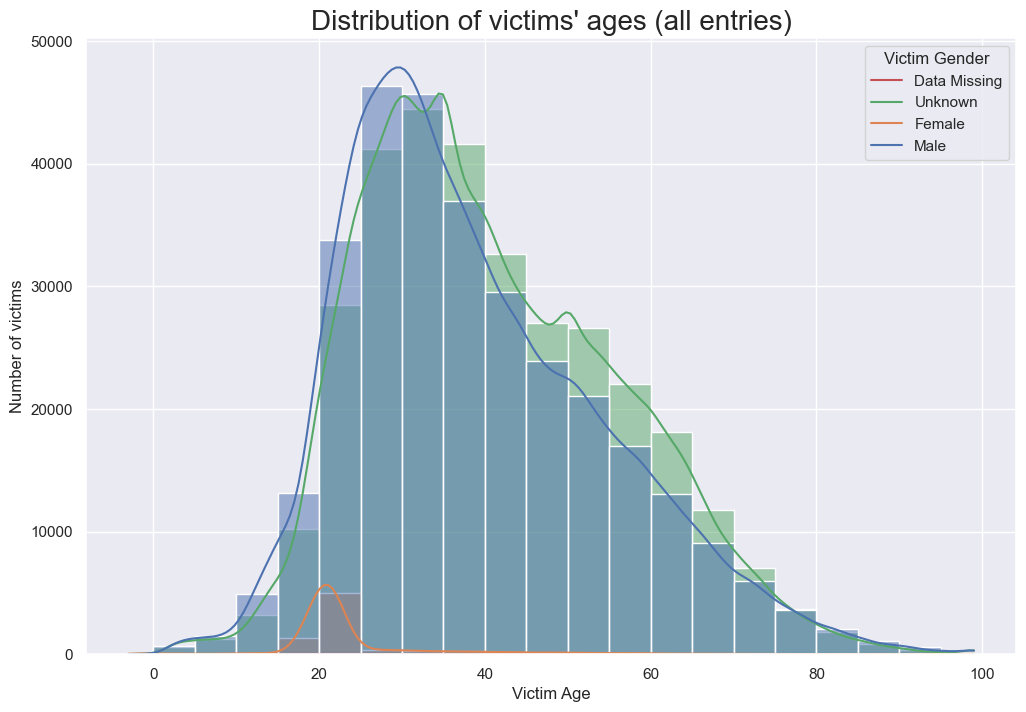

In [64]:
plt.figure(figsize=(12,8))
sns.histplot(data = data[(data['Victim Age']<=100) & (data['Victim Age'] != 0)], x = 'Victim Age', hue = 'Victim Gender', bins = np.arange(0,100,5), kde = True)
plt.title("Distribution of victims' ages (all entries)")
plt.xlabel("Victim Age")
plt.ylabel('Number of victims')
plt.legend(['Data Missing', 'Unknown', 'Female', 'Male'], title = "Victim Gender");

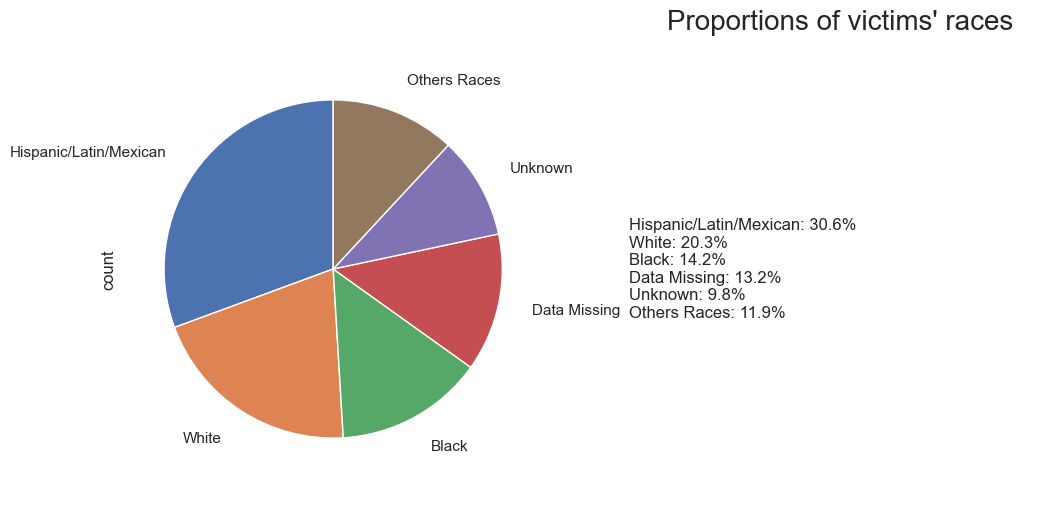

In [65]:
# Assuming data['Victim Descent'] is a categorical variable
value_counts = data['Victim Descent'].value_counts()

# Sorting the value counts in descending order
value_counts = value_counts.sort_values(ascending=False)

# Selecting the top 7 races and combining the rest into 'Others'
top_races = value_counts.head(5)
others_count = value_counts[5:].sum()
top_races['Others Races'] = others_count

# Plotting the pie chart with sorted values
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart on the left
pie_chart = top_races.plot(kind="pie", autopct='', startangle=90, labeldistance=1.2, pctdistance=0.75, legend=False, ax=ax[0])

# Box with percentages on the right
box_text = '\n'.join([f'{race}: {percentage:.1f}%' for race, percentage in zip(top_races.index, (top_races / top_races.sum() * 100))])
ax[1].text(0, 0.5, box_text, ha='left', va='center', fontsize=12)

# Remove axis for a cleaner look
ax[1].axis('off')

plt.title("Proportions of victims' races")
plt.show()


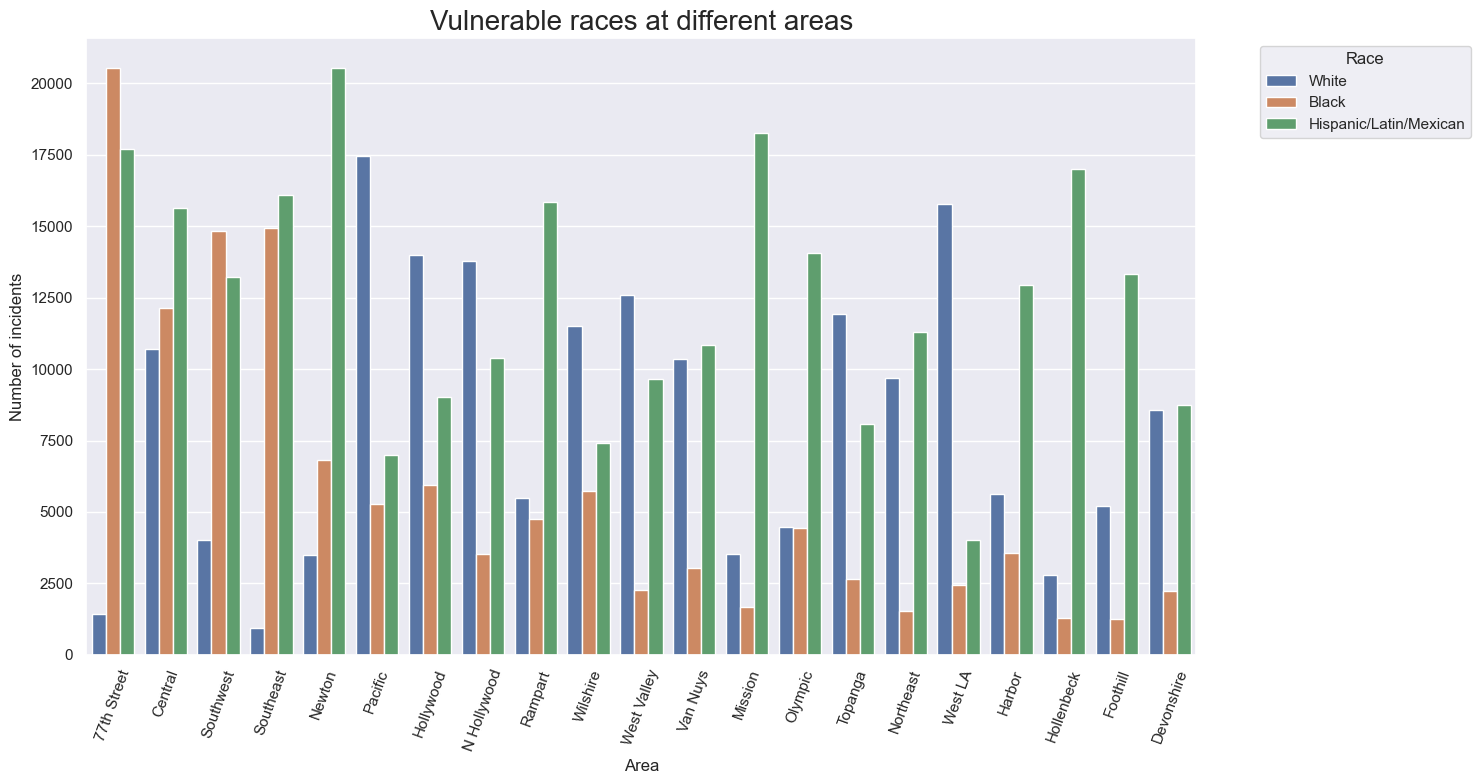

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data['Victim Descent'] is a categorical variable
top_races = data['Victim Descent'].value_counts().head(3).index

# Filtering the data for the top 3 races
filtered_data = data[data['Victim Descent'].isin(top_races)]

# Order the 'Victim Descent' within each 'Area Name' based on crime count in descending order
order_by_count_area = filtered_data.groupby(['Area Name', 'Victim Descent']).size().unstack().sum(axis=1).sort_values(ascending=False).index

plt.figure(figsize=(15, 8))
sns.countplot(data=filtered_data, x="Area Name", hue="Victim Descent", order=order_by_count_area)
plt.xticks(rotation=70)
plt.title("Vulnerable races at different areas")
plt.ylabel("Number of incidents")
plt.xlabel("Area")
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the legend position
plt.tight_layout()  # Automatically adjusts subplot parameters for a cleaner look
plt.show()


In [67]:
data.to_pickle('final_los_angeles_crime_data.pkl')

## Time Series Modelling

In [68]:
time_series_data = data[['Date Occured']][:]

In [69]:
time_series_data = time_series_data.groupby(['Date Occured']).size().reset_index(name='Crime Count')

In [70]:
time_series_data

,Date Occured,Crime Count
0,2020-01-01,1113
1,2020-01-02,527
2,2020-01-03,595
3,2020-01-04,541
4,2020-01-05,505
...,...,...
1429,2023-11-30,485
1430,2023-12-01,536
1431,2023-12-02,495
1432,2023-12-03,393


In [71]:
# Function to get month from a date
def Function_get_month(inpDate):
    return(inpDate.month)

# Function to get Year from a date
def Function_get_year(inpDate):
    return(inpDate.year)

# Creating new columns
time_series_data['Month']=time_series_data['Date Occured'].apply(Function_get_month)
time_series_data['Year']=time_series_data['Date Occured'].apply(Function_get_year)

time_series_data.head()
time_series_data.set_index('Date Occured', inplace=True)
time_series_data.head()

,Crime Count,Month,Year
Date Occured,,,
2020-01-01,1113,1,2020
2020-01-02,527,1,2020
2020-01-03,595,1,2020
2020-01-04,541,1,2020
2020-01-05,505,1,2020


In [72]:
# Aggregating the sales quantity for each month for all categories
pd.crosstab(columns=time_series_data['Month'],
            index=time_series_data['Year'],
            values=time_series_data['Crime Count'],
            aggfunc='sum')

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2020,18496,17255,16165,15683,17204,17034,17121,16874,15639,16491,15574,15946
2021,16552,15411,16320,16057,16989,17156,18659,18374,18362,19305,18340,17926
2022,18448,17700,19687,19784,20418,20201,19952,20081,19279,20274,18688,19924
2023,19633,18313,19024,18775,18738,18500,19697,19743,18861,19394,17358,1545


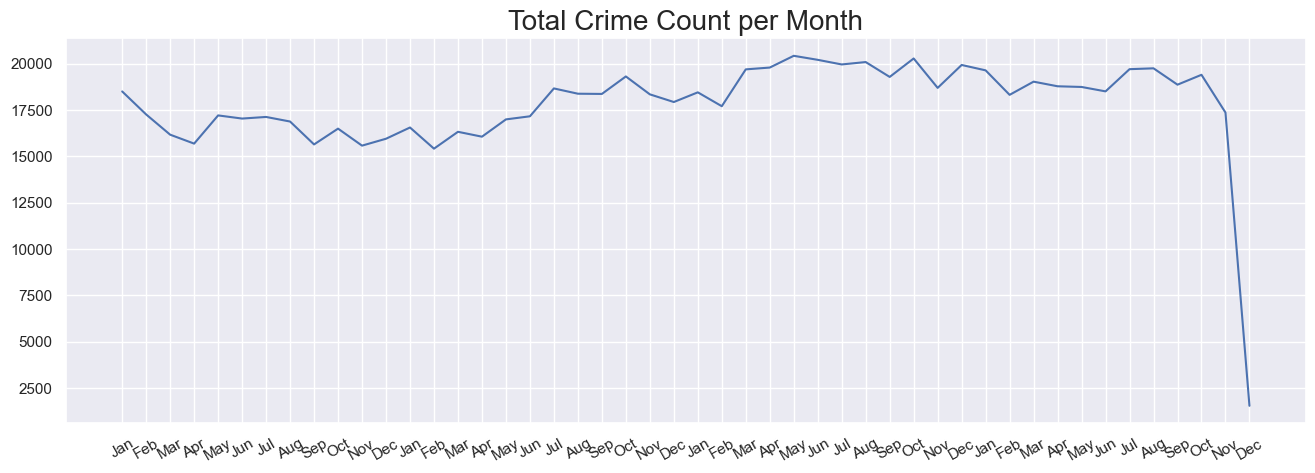

In [73]:
CrimeCount=pd.crosstab(columns=time_series_data['Year'],
            index=time_series_data['Month'],
            values=time_series_data['Crime Count'],
            aggfunc='sum').melt()['value']

MonthNames=['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep','Oct','Nov','Dec']*4

# Plotting the sales
%matplotlib inline
CrimeCount.plot(kind='line', figsize=(16,5), title='Total Crime Count per Month')
# Setting the x-axis labels
plotLabels=plt.xticks(np.arange(0,48,1),MonthNames, rotation=30)

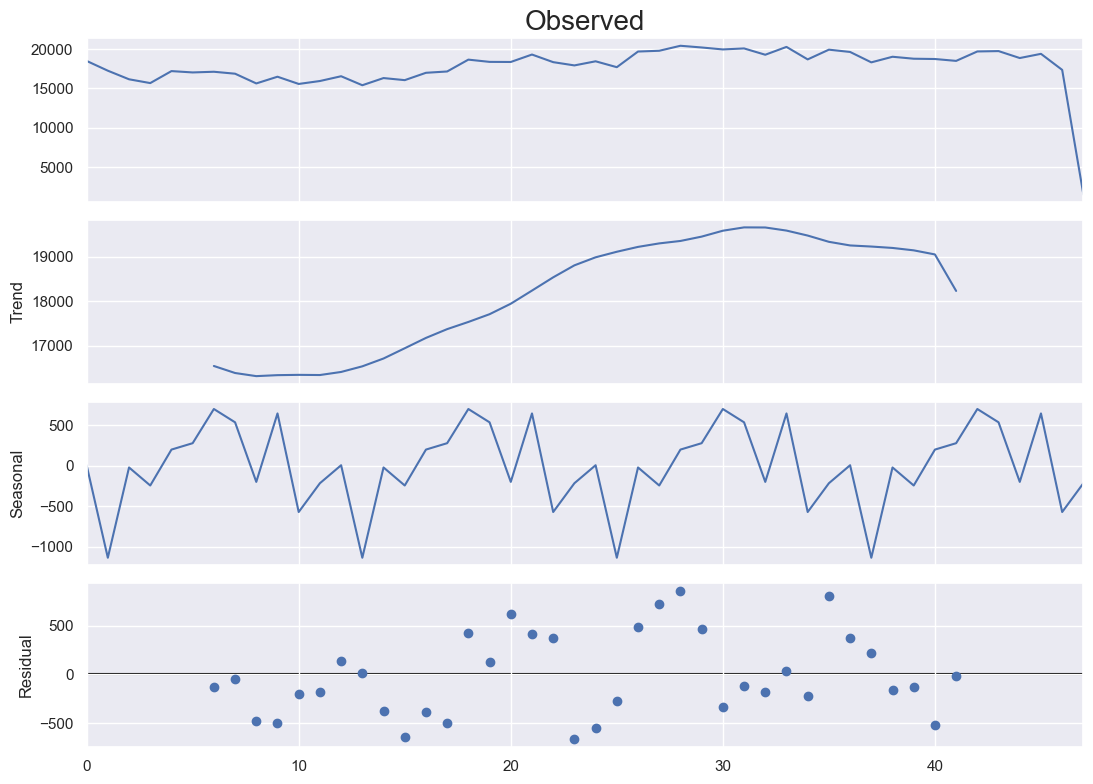

In [74]:
series = CrimeCount.values
result = seasonal_decompose(series, model='additive', period=12)
result.plot()
CurrentFig=plt.gcf()
CurrentFig.set_size_inches(11,8)
plt.show()

In [75]:
CrimeCount = CrimeCount[:len(CrimeCount)-1]

In [76]:
CrimeCount = (CrimeCount/3800000)*100000

C:\Users\subra\AppData\Local\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next Six Month Forecast: 47    500.372847
48    505.393177
49    486.018149
50    526.651176
51    523.699190
52    502.412860
53    504.100406
Name: Forecast, dtype: float64
#### Accuracy of model: 95.09 ####


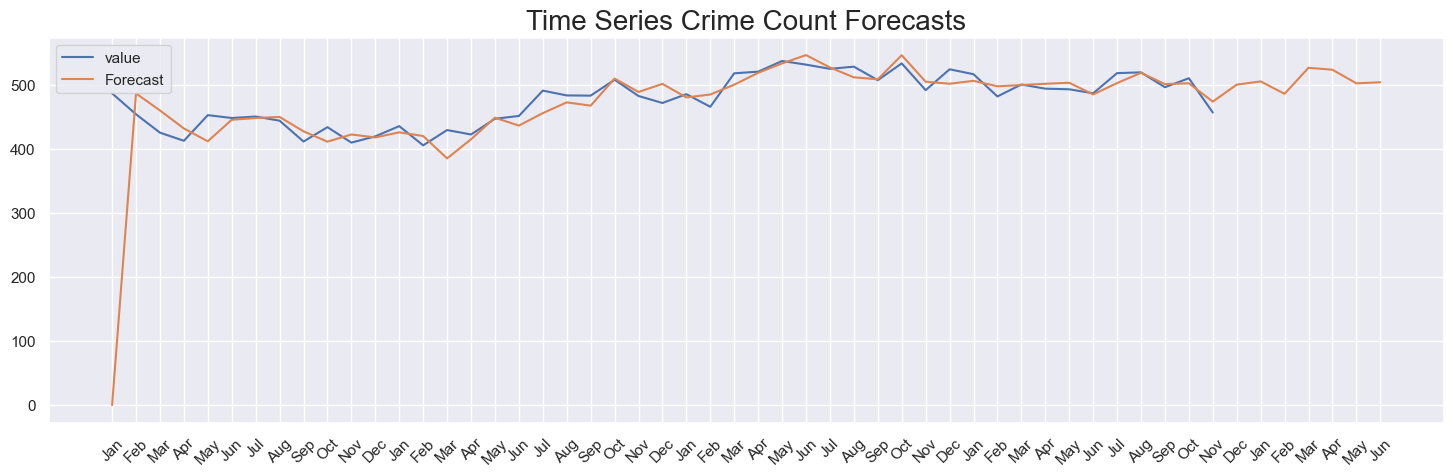

In [77]:
# Train the model on the full dataset 
SarimaxModel = model = SARIMAX(CrimeCount,  
                        order = (5, 1, 10),  
                        seasonal_order =(6, 0, 0, 12))
CrimeModel = SarimaxModel.fit()
  
# Forecast for the next 6 months
forecast = CrimeModel.predict(start = 0,
                          end = (len(CrimeCount)+7)-1,
                          typ = 'levels').rename('Forecast')
print("Next Six Month Forecast:",forecast[-7:])

# Plot the forecast values
CrimeCount.plot(figsize = (10, 15), legend = True, title='Time Series Crime Count Forecasts')
forecast.plot(legend = True, figsize=(18,5))

# Measuring the accuracy of the model
MAPE=np.mean(abs(CrimeCount-forecast)/CrimeCount)*100
print('#### Accuracy of model:', round(100-MAPE,2), '####')

# Printing month names in X-Axis
# Printing month names in X-Axis
MonthNames2=MonthNames+MonthNames[0:6]
plotLabels=plt.xticks(np.arange(0,54,1),MonthNames2, rotation=45)

In [115]:
Months = ['Jan-2020',
         'Feb-2020',
         'Mar-2020',
         'Apr-2020',
         'May-2020',
         'Jun-2020',
         'Jul-2020',
         'Aug-2020',
         'Sep-2020',
         'Oct-2020',
         'Nov-2020',
         'Dec-2020',
         'Jan-2021',
         'Feb-2021',
         'Mar-2021',
         'Apr-2021',
         'May-2021',
         'Jun-2021',
         'Jul-2021',
         'Aug-2021',
         'Sep-2021',
         'Oct-2021',
         'Nov-2021',
         'Dec-2021',
         'Jan-2022',
         'Feb-2022',
         'Mar-2022',
         'Apr-2022',
         'May-2022',
         'Jun-2022',
         'Jul-2022',
         'Aug-2022',
         'Sep-2022',
         'Oct-2022',
         'Nov-2022',
         'Dec-2022',
         'Jan-2023',
         'Feb-2023',
         'Mar-2023',
         'Apr-2023',
         'May-2023',
         'Jun-2023',
         'Jul-2023',
         'Aug-2023',
         'Sep-2023',
         'Oct-2023',
         'Nov-2023',
         'Dec-2023',
         'Jan-2024',
         'Feb-2024',
         'Mar-2024',
         'Apr-2024',
         'May-2024',
         'Jun-2024']

In [123]:
time_series_data_results = pd.DataFrame(data=CrimeCount.values, columns=['Crime_Rate'])
time_series_data_results['Predictions'] = forecast.values
time_series_data_results['Month_Year'] = pd.Series(Months)
time_series_data_results['Sl_no'] = range(len(time_series_data_results))

In [124]:
time_series_data_results

,Crime_Rate,Predictions,Month_Year,Sl_no
0,486.736842,0.000000,Jan-2020,0
1,454.078947,486.685694,Feb-2020,1
2,425.394737,460.057318,Mar-2020,2
3,412.710526,431.934669,Apr-2020,3
4,452.736842,411.906950,May-2020,4
5,448.263158,445.502420,Jun-2020,5
6,450.552632,448.284186,Jul-2020,6
7,444.052632,449.924194,Aug-2020,7
8,411.552632,427.431099,Sep-2020,8
9,433.973684,411.330099,Oct-2020,9


In [77]:
pd.read_pickle('final_los_angeles_crime_data.pkl').head()

,Dr No,Date Reported,Date Occured,Time Occured,Area Code,Area Name,Rpt Dist No,Part 1-2,Crime Code,Crime Description,...,Latitude,Longitude,Weapon Description,Cross Street,Age Group,Delay,Delay Category,Week Period,Month Period,Time Slot
0,191501505,2020-01-01,2020-01-01,17,15,N Hollywood,1543,2,745,Vandalism - Misdeameanor,...,34.1685,-118.4019,Data Missing,Data Missing,Old,0,Same day,2019-12-30,2020-01-01,16-18
1,191921269,2020-01-01,2020-01-01,4,19,Mission,1998,2,740,Vandalism - Felony,...,34.2198,-118.4468,Data Missing,Data Missing,Adult,0,Same day,2019-12-30,2020-01-01,4-6
2,200104020,2020-01-01,2020-01-01,2,1,Central,153,1,350,Theft- Person,...,34.0463,-118.2515,Strong-Arm,SPRING ST,Adult,0,Same day,2019-12-30,2020-01-01,2-4
3,200104024,2020-01-01,2020-01-01,3,1,Central,134,2,740,Vandalism - Felony,...,34.0503,-118.2504,Data Missing,HILL ST,Adult,0,Same day,2019-12-30,2020-01-01,2-4
4,200104027,2020-01-01,2020-01-01,0,1,Central,182,2,930,Criminal Threats - No Weapon Displayed,...,34.0458,-118.2614,Strong-Arm,Data Missing,Adult,0,Same day,2019-12-30,2020-01-01,0-2


In [78]:
from pandas.io import gbq

In [84]:
gbq_data = data[:]
columns = []
for column in gbq_data.columns:
    column = column.replace(" ", "_")
    column = column.replace("-", "_")
    columns.append(column)
gbq_data.columns = columns
gbq_data.columns

Index(['Dr_No', 'Date_Reported', 'Date_Occured', 'Time_Occured', 'Area_Code',
       'Area_Name', 'Rpt_Dist_No', 'Part_1_2', 'Crime_Code',
       'Crime_Description', 'Modus_Operandi', 'Victim_Age', 'Victim_Gender',
       'Victim_Descent', 'Crime_Location', 'Case_Status', 'Street_Address',
       'Latitude', 'Longitude', 'Weapon_Description', 'Cross_Street',
       'Age_Group', 'Delay', 'Delay_Category', 'Week_Period', 'Month_Period',
       'Time_Slot'],
      dtype='object')

In [85]:
gbq_data.to_gbq(destination_table='los_angeles.la_crime_data',
           project_id='lacrimedataanalysis',
           if_exists='replace')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [125]:
gbq_data_sarimax = time_series_data_results[:]

In [126]:
gbq_data_sarimax.to_gbq(destination_table='los_angeles.time_series_predictions',
           project_id='lacrimedataanalysis',
           if_exists='replace')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
